In [296]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
import sys
import copy
import numpy as np
import pandas as pd
import sklearn
from sklearn import cluster, datasets, mixture
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
import seaborn as sns
from ExKMC.Tree import Tree as ExTree
from graphviz import Source
#from scikit_obliquetree.HHCART import HouseHolderCART
#from scikit_obliquetree.segmentor import MSE, MeanSegmentor

sys.path.append("../main")
from tree import *
from rules import *
from tree_rules import *
from rule_clustering import *
from utils import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# NOTE: The following is important for recreating results, 
# But can be changed for randomized analysis.
seed = 170
np.random.seed(seed)

In [3]:
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "font.serif": [],
    "text.usetex": True,
    "pgf.rcfonts": False,
    "font.size": 12
})

colorblind_palette = sns.color_palette("colorblind", as_cmap=False)
cmap = ListedColormap(colorblind_palette)
subset_colors = [cmap(0), cmap(4), cmap(9)]
cmap_subset = ListedColormap(subset_colors)

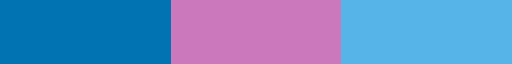

In [4]:
cmap_subset

## Simple Dataset

In [5]:
n = 2000
m = 2
k = 3

random_state = 170
data, labels = datasets.make_blobs(
    n_samples=n, cluster_std=[1.0, 2.5, 0.5], random_state=seed
)
data = preprocessing.MinMaxScaler().fit_transform(data)

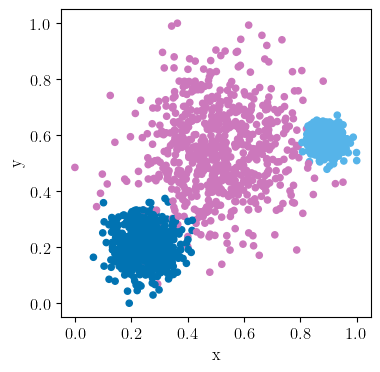

In [6]:
fig,ax = plt.subplots(figsize = (4,4), dpi = 100)
ax.scatter(data[:,0], data[:,1], c = labels, cmap = cmap_subset, alpha = 1, s = 20)
ax.set_xlabel('x')
ax.set_ylabel('y')
#plt.savefig('figures/example_ground_truth.jpg', bbox_inches = 'tight', dpi = 300)

In [217]:
point = data[10,:]
# 0 slope:
weights = np.array([0,1])
threshold = point[1]

# INF slope
weights = np.array([1,0])
threshold = point[0]

# Slope 1
weights = np.array([1,1])
threshold = 

In [263]:
slopes = np.array([[0,1],
                  [1,2],
                  [1,1],
                  [2,1],
                  [1,0],
                  [2,-1],
                  [1,-1],
                  [1,-2]])

In [292]:
slope = slopes[7]
weights = np.array([slope[1], -slope[0]])
threshold = slope[1]*point[0] - slope[0]*point[1]

In [293]:
left_mask = np.dot(data, weights) <= threshold
right_mask = ~left_mask

In [294]:
line = (threshold - weights[0]*np.linspace(0,1,10))/weights[1]

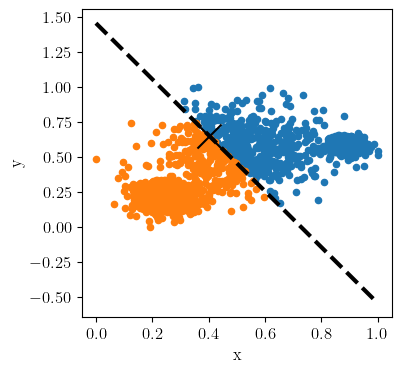

In [295]:
fig,ax = plt.subplots(figsize = (4,4), dpi = 100)
ax.scatter(data[left_mask,0], data[left_mask,1], s = 20)
ax.scatter(data[right_mask,0], data[right_mask,1], s = 20)
ax.plot(np.linspace(0,1,10), line, c = 'k', linestyle = '--', linewidth = 3)
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.scatter(point[0], point[1], marker = 'x', s = 300, c = 'k')

### Kmeans baseline

In [171]:
kmeans = KMeans(n_clusters=k, random_state=seed).fit(data)
kmeans_clustering = labels_to_clustering(kmeans.labels_)
cost = kmeans_cost(data, kmeans_clustering, kmeans.cluster_centers_)

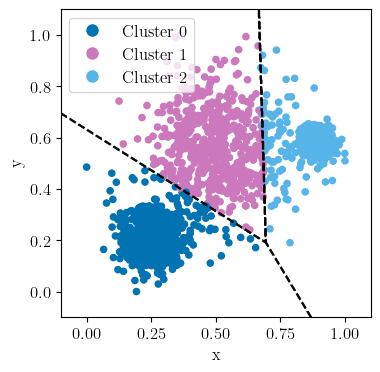

In [172]:
colorswitch = {0:2, 1:0, 2:1}
kmeans_labels_ = np.array([colorswitch[i] for i in kmeans.labels_])
fig,ax = plt.subplots(figsize = (4,4), dpi = 100)
scatter = ax.scatter(data[:,0], data[:,1], c = kmeans_labels_, cmap = cmap_subset, s = 20)
plot_decision_boundaries(kmeans, data, ax = ax, resolution = 1000)

unique_labels = np.unique(kmeans.labels_)
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=10, label=f'Cluster {label}') for label in unique_labels]

ax.set_xlabel('x')
ax.set_ylabel('y')
plt.legend(handles=handles, loc = 'upper left')
#plt.savefig('figures/example_kmeans.jpg', bbox_inches = 'tight', dpi = 300)

In [126]:
Centers = kmeans.cluster_centers_

In [143]:
weights = Centers[1,:] - Centers[0,:]
threshold = (Centers[1,0]**2 - Centers[0,0]**2 + Centers[1,1]**2 - Centers[0,1]**2)/2

In [144]:
left_mask = np.dot(data, weights) <= threshold
right_mask = ~left_mask

In [145]:
left_mask

array([ True, False,  True, ...,  True,  True,  True])

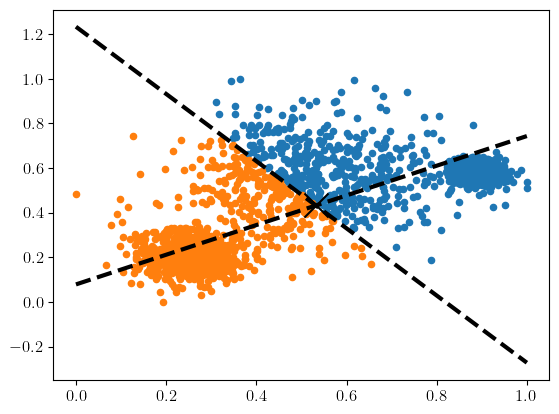

In [148]:
plt.scatter(data[left_mask,0], data[left_mask,1], s = 20)
plt.scatter(data[right_mask,0], data[right_mask,1], s = 20)
plt.plot(np.linspace(0,1,10), line, c = 'k', linestyle = '--', linewidth = 3)
plt.plot(np.linspace(0,1,10), perpendicular_line, c = 'k', linestyle = '--', linewidth = 3)
plt.scatter(midpoint[0], midpoint[1], marker = 'x', s = 300, c = 'k')

In [9]:
kmeans_cost(data, labels_to_clustering(kmeans.labels_), kmeans.cluster_centers_)

27.89047031601499

In [83]:
kmeans.score(data)

-27.890470316015005

### ExKMC Baseline

In [10]:
ExKMC_tree = ExTree(k, max_leaves = 4)
exkmc_labels = ExKMC_tree.fit_predict(data, kmeans)

Text(0, 0.5, 'y')

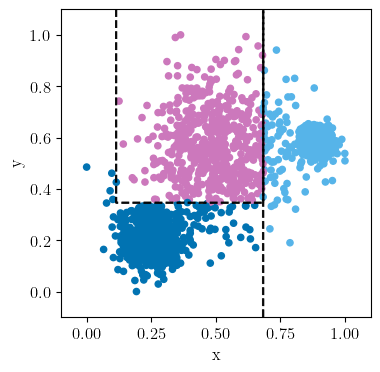

In [11]:
colorswitch = {0:2, 1:0, 2:1}
exkmc_labels_ = np.array([colorswitch[i] for i in exkmc_labels])

fig,ax = plt.subplots(figsize = (4,4), dpi = 100)
ax.scatter(data[:,0], data[:,1], c = exkmc_labels_, cmap = cmap_subset, s = 20)
plot_decision_boundaries(ExKMC_tree, data, ax = ax, resolution = 1000)
ax.set_xlabel('x')
ax.set_ylabel('y')
#plt.savefig('figures/example_imm.jpg', bbox_inches = 'tight', dpi = 300)

# Creating Rule sets

### Grid Partition

In [12]:
cells = 5
grid = rule_grid(data,cells)
# This actually does a clustering with cells x cells clusters just for visualization purposes
grid_rules = RuleClustering(grid, k_clusters = cells**2)
grid_rules.fit_rules(data)
grid_labels = grid_rules.predict(data)

Text(0, 0.5, 'y')

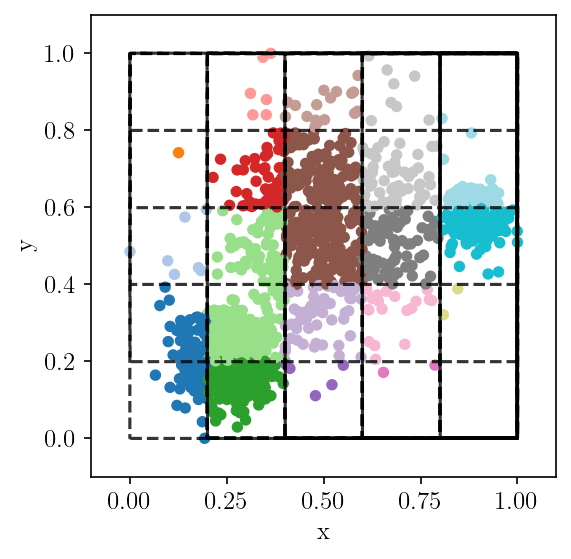

In [13]:
#scatter = plt.scatter(data2[select,0], data2[select,1])
fig,ax = plt.subplots(figsize = (4,4), dpi = 150)
ax.scatter(data[:,0], data[:,1], c = grid_labels, cmap = 'tab20', s = 20)
plot_decision_boundaries(grid_rules, data, ax = ax, resolution = 1000)
ax.set_xlabel('x')
ax.set_ylabel('y')

### k-Means Tree Partition

In [306]:
kmeans_tree = KMeansTree(max_leaf_nodes = 6, min_points_leaf = 1, centers = kmeans.cluster_centers_)
kmeans_tree.fit(data)
kmeans_tree_labels = kmeans_tree.predict(data)

Text(0, 0.5, 'y')

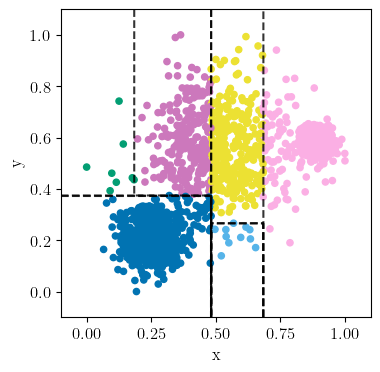

In [307]:
fig,ax = plt.subplots(figsize = (4,4), dpi = 100)
scatter = ax.scatter(data[:,0], data[:,1], c = kmeans_tree_labels, cmap = cmap, s = 20)
plot_decision_boundaries(kmeans_tree, data, ax = ax, resolution = 1000)
ax.set_xlabel('x')
ax.set_ylabel('y')
#plt.savefig('figures/example_kmeans_tree.jpg', bbox_inches = 'tight', dpi = 300)

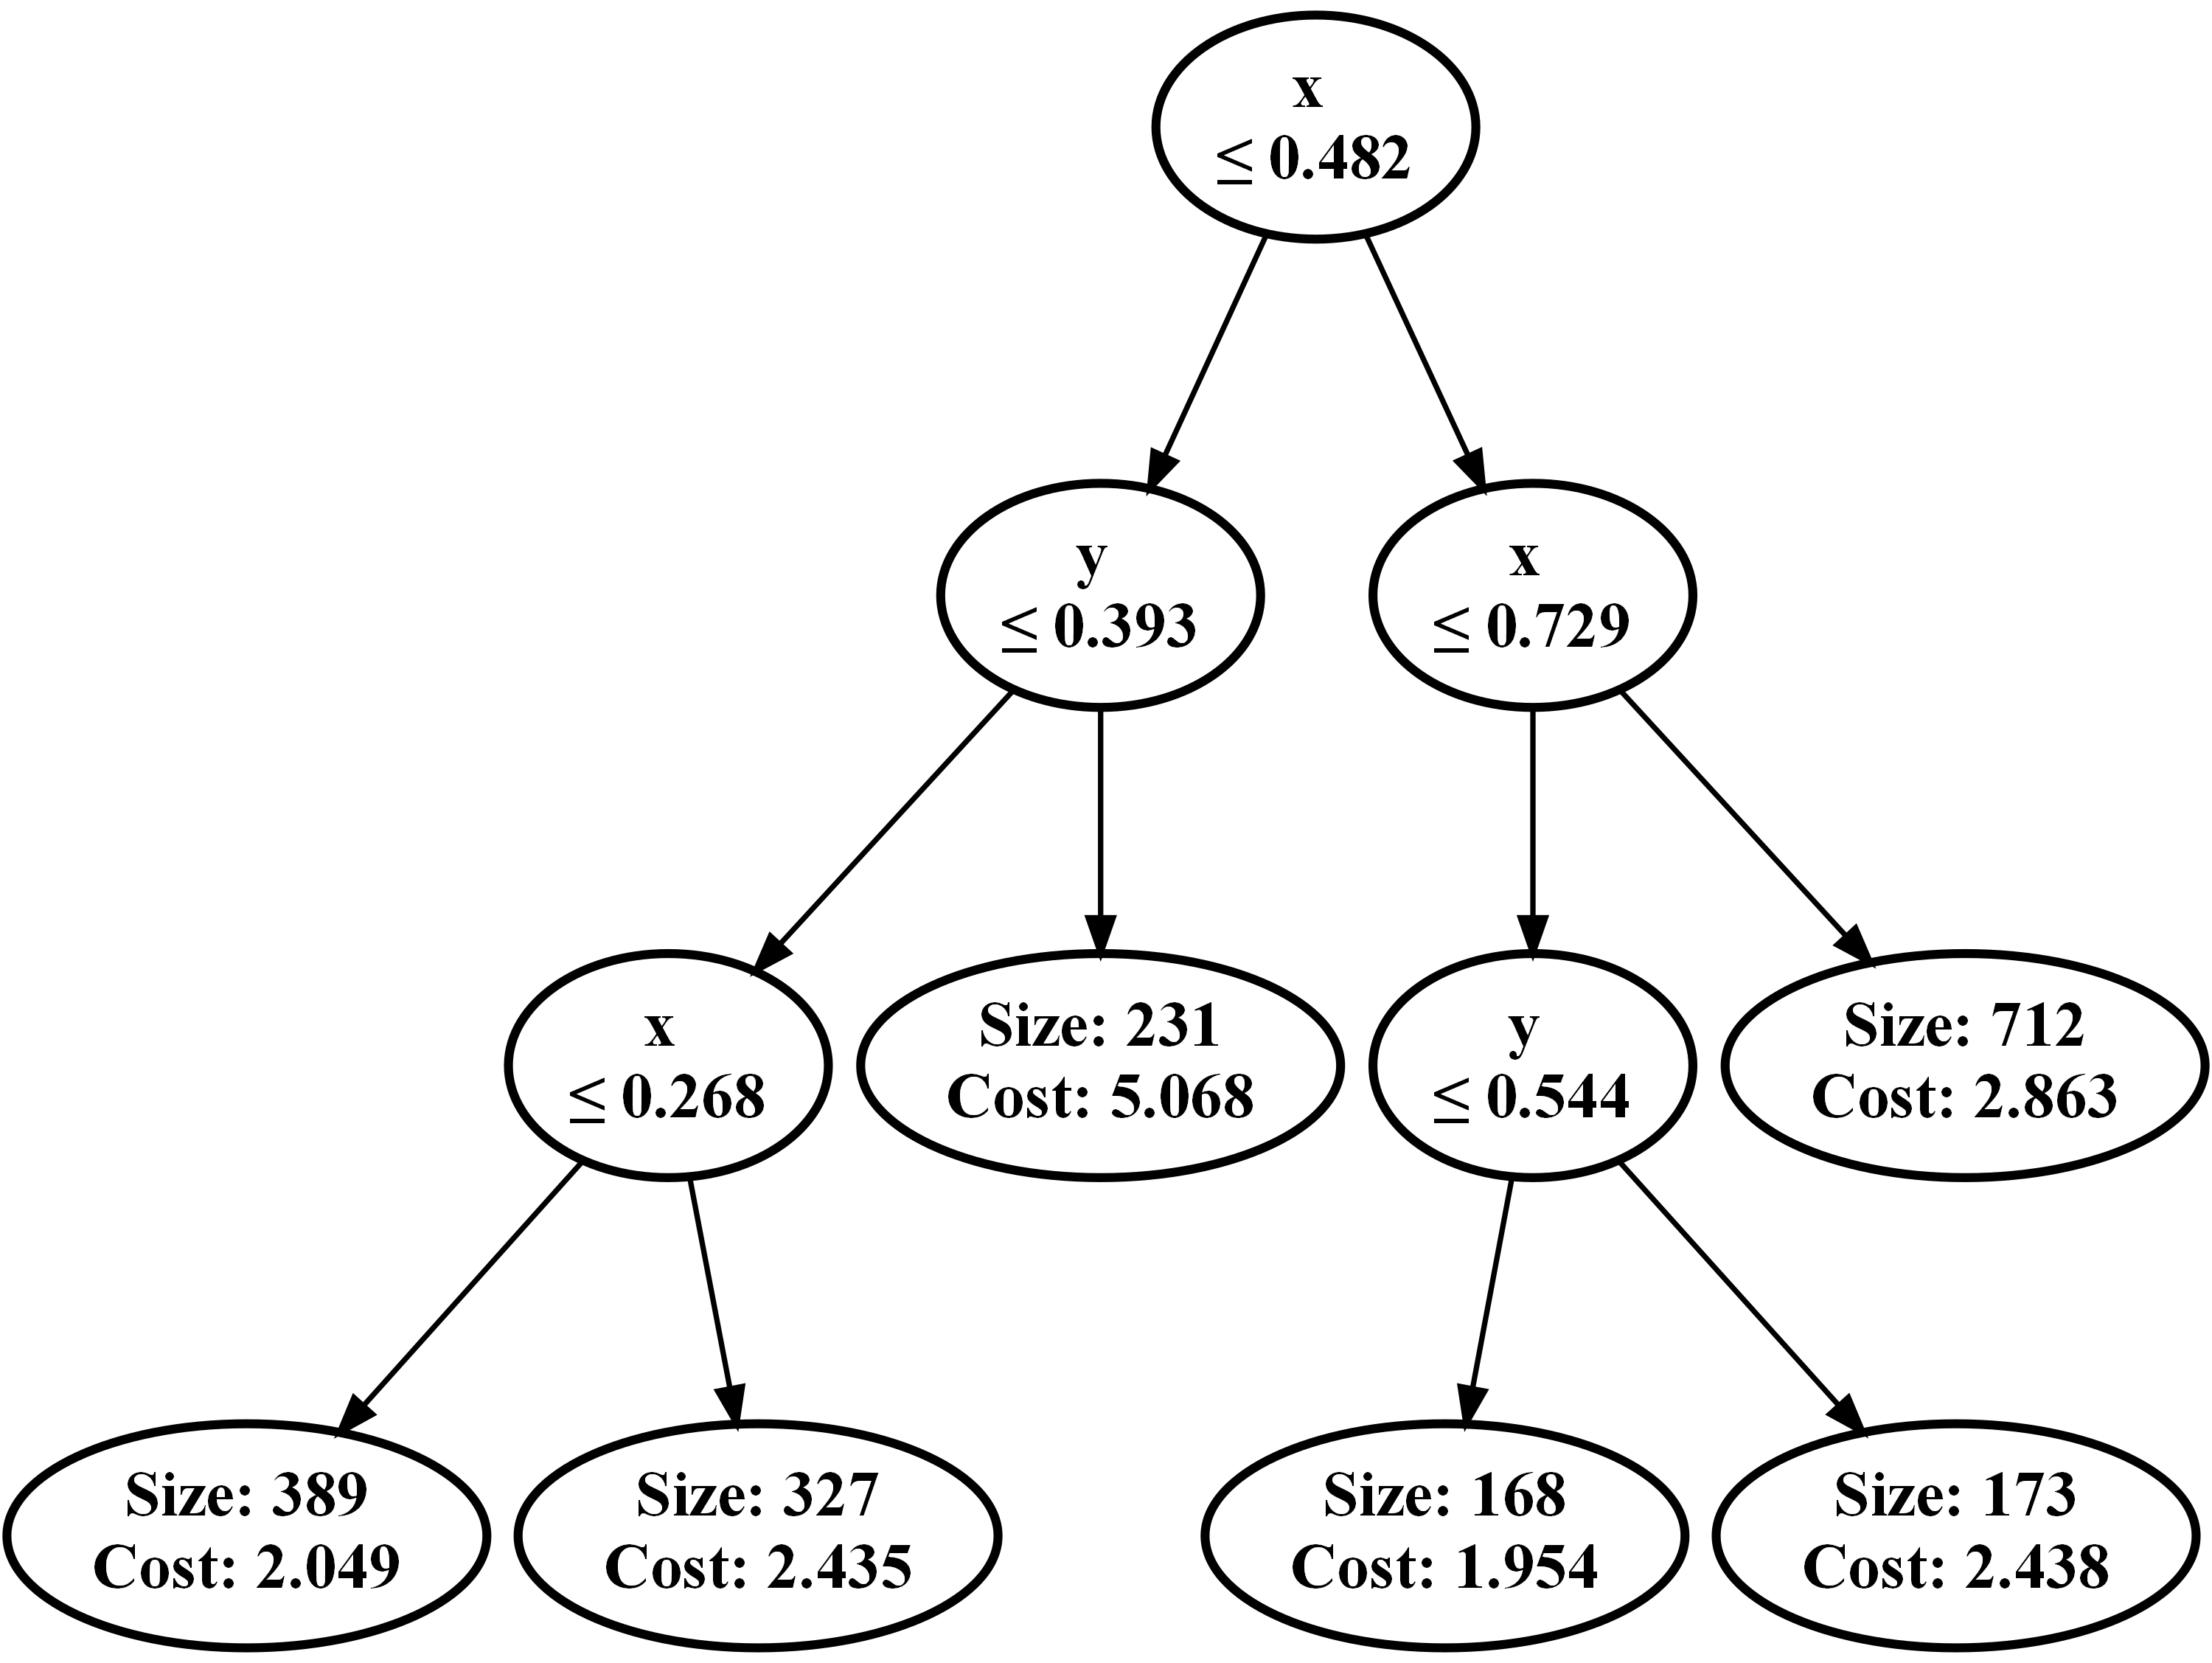

In [16]:
visualize_tree(kmeans_tree.root, feature_labels = ['x', 'y'])

In [17]:
tree_traverse = tree_to_rules()
kmeans_rules = tree_traverse.traverse(kmeans_tree.root)
leaf_node_labels = tree_traverse.leaf_node_labels

In [18]:
kmeans_rules

[(x0 <= 0.4818446633222401  ∧  x1 <= 0.3925631481508086  ∧  x0 <= 0.2677466321927099),
 (x0 <= 0.4818446633222401  ∧  x1 <= 0.3925631481508086  ∧  x0 > 0.2677466321927099),
 (x0 <= 0.4818446633222401  ∧  x1 > 0.3925631481508086),
 (x0 > 0.4818446633222401  ∧  x0 <= 0.7285337832335166  ∧  x1 <= 0.5441114975168548),
 (x0 > 0.4818446633222401  ∧  x0 <= 0.7285337832335166  ∧  x1 > 0.5441114975168548),
 (x0 > 0.4818446633222401  ∧  x0 > 0.7285337832335166)]

### k-Medians Tree Partition

In [19]:
kmedians_tree = KMediansTree(max_leaf_nodes = 32, min_points_leaf = 1)
kmedians_tree.fit(data)
kmedians_tree_labels = kmedians_tree.predict(data)

Text(0, 0.5, 'y')

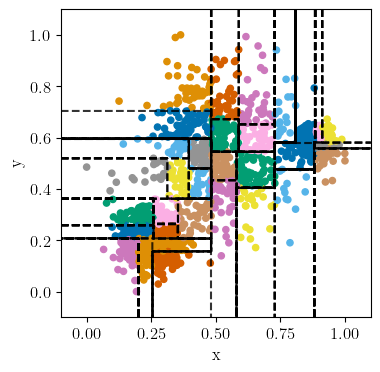

In [20]:
fig,ax = plt.subplots(figsize = (4,4), dpi = 100)
scatter = ax.scatter(data[:,0], data[:,1], c = kmedians_tree_labels, cmap = cmap, s = 20)
plot_decision_boundaries(kmedians_tree, data, ax = ax, resolution = 1000)
ax.set_xlabel('x')
ax.set_ylabel('y')

In [21]:
kmedians_rules = tree_to_rules().traverse(kmedians_tree.root)

### ExKMC Tree

In [304]:
# ExKMC
ExKMC_tree = ExTree(k, max_leaves = 6, base_tree='NONE')
exkmc_labels = ExKMC_tree.fit_predict(data, kmeans)
exkmc_tree = ConvertExKMC(ExKMC_tree.tree, data)
exkmc_tree_labels = exkmc_tree.predict(data)

In [70]:
exkmc_tree.fit(data)
exkmc_tree.predict(data)

array([5, 0, 5, ..., 5, 5, 4])

In [67]:
exkmc_tree

Text(0, 0.5, 'y')

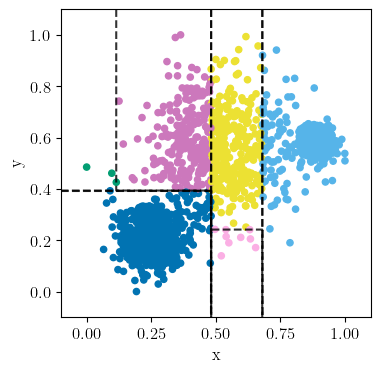

In [305]:
fig,ax = plt.subplots(figsize = (4,4), dpi = 100)
scatter = ax.scatter(data[:,0], data[:,1], c = exkmc_tree_labels, cmap = cmap, s = 20)
plot_decision_boundaries(exkmc_tree, data, ax = ax, resolution = 1000)
ax.set_xlabel('x')
ax.set_ylabel('y')

In [24]:
exkmc_rules = tree_to_rules().traverse(exkmc_tree.root)

### CART

In [74]:
k_ = 16
kmeans_extend = KMeans(n_clusters=k, random_state=seed).fit(data)
dtree = DecisionTreeClassifier(criterion='entropy', max_leaf_nodes = k_)
dtree.fit(data, kmeans_extend.labels_)
kmeans_dtree = ConvertSklearn(dtree.tree_, data)
kmeans_dtree_labels = kmeans_dtree.predict(data)

Text(0, 0.5, 'y')

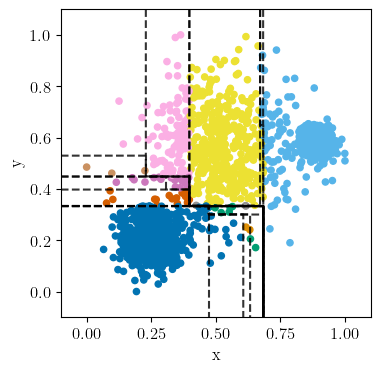

In [77]:
fig,ax = plt.subplots(figsize = (4,4), dpi = 100)
scatter = ax.scatter(data[:,0], data[:,1], c = kmeans_dtree_labels, cmap = cmap, s = 20)
plot_decision_boundaries(kmeans_dtree, data, ax = ax, resolution = 1000)
ax.set_xlabel('x')
ax.set_ylabel('y')

In [47]:
kmeans_dtree_rules = tree_to_rules().traverse(kmeans_dtree.root)

### Oblique Tree

In [103]:
'''
k_ = 3
kmeans_extend = KMeans(n_clusters=k, random_state=seed).fit(data)
obtree = HouseHolderCART(MSE(), MeanSegmentor(), max_depth = 20)
obtree.fit(data, kmeans_extend.labels_)
obtree_labels = obtree.predict(data)
'''

In [297]:
obtree = KMeansObliqueTree3(max_leaf_nodes = 6, min_points_leaf = 1)
obtree.fit(data)
obtree_labels = obtree.predict(data)

Text(0, 0.5, 'y')

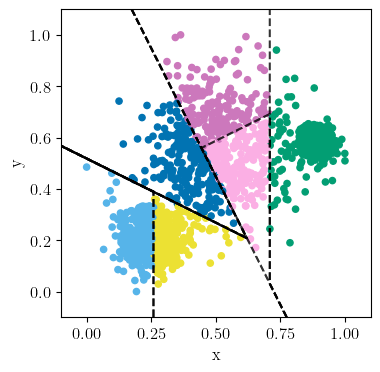

In [298]:
fig,ax = plt.subplots(figsize = (4,4), dpi = 100)
scatter = ax.scatter(data[:,0], data[:,1], c = obtree_labels, cmap = cmap, s = 20)
plot_decision_boundaries(obtree, data, ax = ax, resolution = 1000)
ax.set_xlabel('x')
ax.set_ylabel('y')

# Rule Clustering

### 1. k-Means

In [203]:
rule_kmeans = KMeansRuleClustering(obtree, k_clusters = 6, init = 'k-means', n_init = 10)
rule_kmeans.fit(data)
rule_labels = rule_kmeans.labels
rule_kmeans_labels = rule_kmeans.predict(data)

In [204]:
rule_kmeans.cost

18.50000521578752

In [207]:
rule_kmeans = KMeansRuleClustering(exkmc_tree, k_clusters = 6, init = 'k-means', n_init = 10)
rule_kmeans.fit(data)
rule_labels = rule_kmeans.labels
rule_kmeans_labels = rule_kmeans.predict(data)

In [208]:
rule_kmeans.cost

26.888916167318026

In [205]:
cost

27.89047031601499

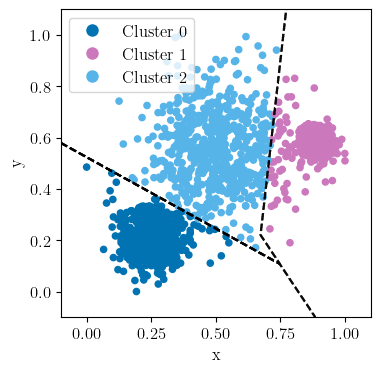

In [169]:
#plt.scatter(rule_kmeans.centers[:,0], rule_kmeans.centers[:,1], color = 'k', marker = 'x', s = 100)
colorswitch = {0:1, 1:0, 2:2}
rule_kmeans_labels_ = np.array([colorswitch[i] for i in rule_kmeans_labels])

fig,ax = plt.subplots(figsize = (4,4), dpi = 100)
scatter = ax.scatter(data[:,0], data[:,1], c = rule_kmeans_labels, cmap = cmap_subset, s = 20)
plot_decision_boundaries(rule_kmeans, data, ax = ax, resolution = 1000)

unique_labels = np.unique(rule_kmeans_labels)
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=10, label=f'Cluster {int(label)}') 
           if label != -1 else plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=10, label='Unclustered') 
        for label in unique_labels]

ax.set_xlabel('x')
ax.set_ylabel('y')
plt.legend(handles=handles, loc = 'upper left')
#plt.savefig('figures/example_rule_cluster.jpg', bbox_inches = 'tight', dpi = 300)

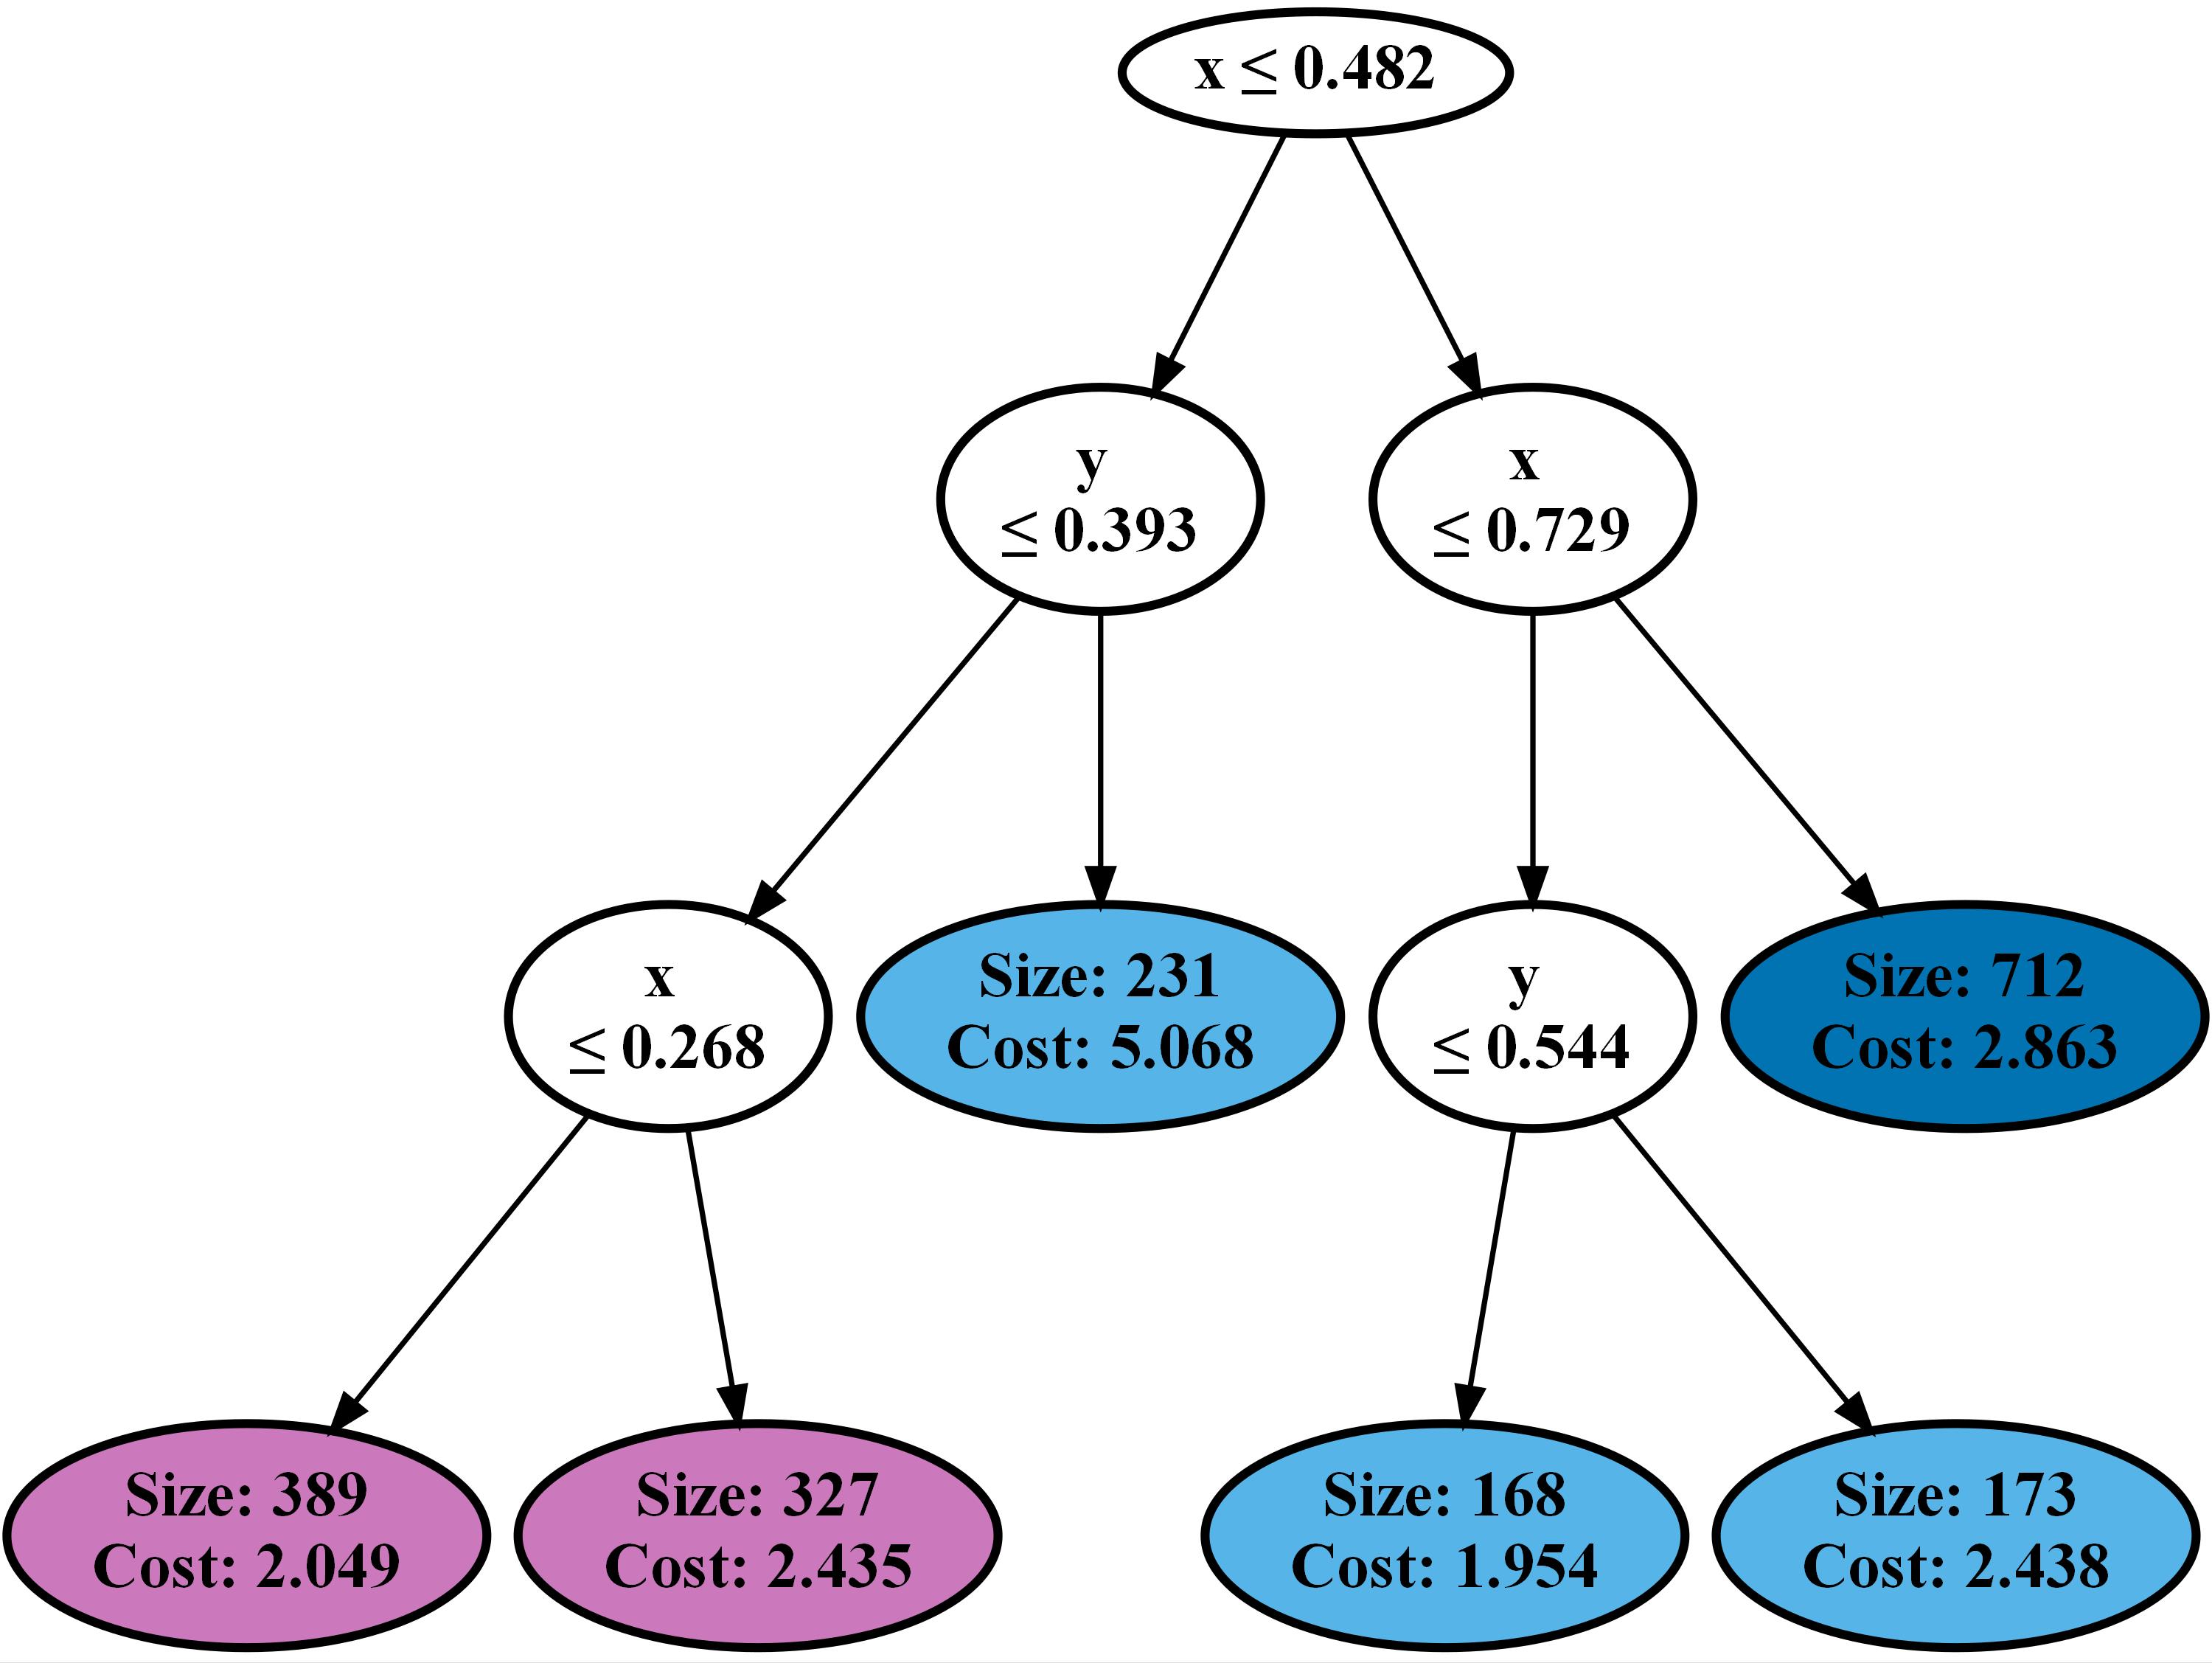

In [137]:
rule_labels_ = [colorswitch[i] for i in rule_labels]
leaf_colors = {leaf_node_labels[i]:mcolors.rgb2hex(cmap_subset(rule_labels_[i]), keep_alpha=True) for i in range(len(leaf_node_labels))}
visualize_tree(kmeans_tree.root, output_file = 'figures/example_tree.jpg', feature_labels = ['x', 'y'], leaf_colors = leaf_colors, newline = False)

In [148]:
print(rule_kmeans)

IF:
(x0 > 0.683189395126272)
THEN CLUSTER 0

IF:
(x1 <= 0.3467226668645854  ∧  x0 <= 0.5504677135763472)  ∨  
(x0 <= 0.683189395126272  ∧  x0 > 0.5504677135763472  ∧  x1 <= 0.21093899149602607)  ∨  
(x1 > 0.3467226668645854  ∧  x0 <= 0.11478821946041329)
THEN CLUSTER 1

IF:
(x0 <= 0.683189395126272  ∧  x1 <= 0.3467226668645854  ∧  x0 > 0.5504677135763472  ∧  x1 > 0.21093899149602607)  ∨  
(x0 <= 0.683189395126272  ∧  x1 > 0.3467226668645854  ∧  x0 > 0.11478821946041329)
THEN CLUSTER 2



In [195]:
# Revert the seed in case it has been advanced anywhere else:
np.random.seed(seed)

leaves = list(range(k,32))
exkmc_leaves_cost = []
rule_kmeans_leaves_cost = []
rule_kmeans_random_leaves_cost = []
rule_exkmc_leaves_cost = []
rule_cart_leaves_cost =[]
rule_oblique_leaves_cost = []

rule_kmeans_iterations = []
rule_kmeans_random_iterations = []
rule_exkmc_iterations = []
rule_cart_iterations = []
rule_oblique_iterations = []

for l in leaves:
    # ExKMC
    ExKMC_tree_ = ExTree(k, max_leaves = l)
    exkmc_labs_ = ExKMC_tree_.fit_predict(data, kmeans)
    exkmc_clustering_ = labels_to_clustering(exkmc_labs_)
    exkmc_centers_ = ExKMC_tree_.all_centers
    exkmc_cost_ = kmeans_cost(data, exkmc_clustering_, exkmc_centers_)
    exkmc_leaves_cost.append(exkmc_cost_)
    
    # Rule KMeans
    kmeans_tree_ = KMeansTree(max_leaf_nodes = l, min_points_leaf = 1)
    kmeans_tree_.fit(data)

    # With KMeans centers
    rule_kmeans_ = KMeansRuleClustering(kmeans_tree_, k_clusters = k, init = 'manual', center_init = kmeans.cluster_centers_, random_seed = seed)
    rule_kmeans_.fit(data)
    data_clustering_, data_labels_ = rule_kmeans_.predict(data, return_clustering = True)
    rule_kmeans_leaves_cost.append(rule_kmeans_.cost)
    rule_kmeans_iterations.append(rule_kmeans_.iterations)

    # With random++ centers
    rule_kmeans_random_ = KMeansRuleClustering(kmeans_tree_, k_clusters = k, init = 'random++', n_init = 10, random_seed = seed)
    rule_kmeans_random_.fit(data)
    data_clustering_random_, data_labels_random_ = rule_kmeans_random_.predict(data, return_clustering = True)
    rule_kmeans_random_leaves_cost.append(rule_kmeans_random_.cost)
    rule_kmeans_random_iterations.append(rule_kmeans_random_.iterations)

    # Rule ExKMC KMeans
    exkmc_tree_ = ConvertExKMC(ExKMC_tree_.tree, data)
    rule_exkmc_ = KMeansRuleClustering(exkmc_tree_, k_clusters = k, init = 'manual', center_init = kmeans.cluster_centers_,)
    rule_exkmc_.fit(data)
    data_clustering_exkmc_, data_labels_exkmc_ = rule_exkmc_.predict(data, return_clustering = True)
    rule_exkmc_leaves_cost.append(rule_exkmc_.cost)
    rule_exkmc_iterations.append(rule_exkmc_.iterations)

    # Rule kmeans decision tree
    kmeans_extend_ = KMeans(n_clusters=k, random_state=seed).fit(data)
    dtree_ = DecisionTreeClassifier(criterion='entropy', max_leaf_nodes = l)
    dtree_.fit(data, kmeans_extend_.labels_)
    kmeans_dtree_ = ConvertSklearn(dtree_.tree_, data)

    rule_cart_ = KMeansRuleClustering(kmeans_dtree_, k_clusters = k, init = 'manual', center_init = kmeans.cluster_centers_,)
    rule_cart_.fit(data)
    data_clustering_cart_, data_labels_cart_ = rule_cart_.predict(data, return_clustering = True)
    rule_cart_leaves_cost.append(rule_cart_.cost)
    rule_cart_iterations.append(rule_cart_.iterations)

    # Oblique Tree
    obtree_ = KMeansObliqueTree(max_leaf_nodes = l, min_points_leaf = 1)
    obtree_.fit(data)

    rule_oblique_ = KMeansRuleClustering(obtree_, k_clusters = k, init = 'manual', center_init = kmeans.cluster_centers_, random_seed = seed)
    rule_oblique_.fit(data)
    data_clustering_, data_labels_ = rule_oblique_.predict(data, return_clustering = True)
    rule_oblique_leaves_cost.append(rule_oblique_.cost)
    rule_oblique_iterations.append(rule_oblique_.iterations)

C:\Users\kq146\anaconda3\envs\ex_cluster\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\kq146\anaconda3\envs\ex_cluster\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\kq146\anaconda3\envs\ex_cluster\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\kq146\anaconda3\envs\ex_cluster\lib\site-packages\sklearn\cluster\_kmeans.py:14

In [49]:
# Rule Grid KMeans
rule_kmeans_2 = KMeansRuleClustering(grid, k_clusters = k, init = 'k-means')
rule_kmeans_2.fit(data)
rule_kmeans_labs2 = rule_kmeans_2.predict(data)

rule_grid_cost = kmeans_cost(data, labels_to_clustering(rule_kmeans_labs2), rule_kmeans_2.centers)

In [50]:
# Svensson Random Tree for comparison:
random_tree_cost = np.inf
for i in range(10000):
    random_tree = RandomTree(max_leaf_nodes = k, min_points_leaf = 1)
    random_tree.fit(kmeans.cluster_centers_)
    random_tree_labels = random_tree.predict(data)
    rcost = kmeans_cost(data, labels_to_clustering(random_tree_labels), kmeans.cluster_centers_)
    if rcost < random_tree_cost:
        random_tree_cost = rcost

In [ ]:
exkmc_leaves_cost = []
rule_kmeans_leaves_cost = []
rule_kmeans_random_leaves_cost = []
rule_exkmc_leaves_cost = []
rule_cart_leaves_cost =[]
rule_oblique_leaves_cost = []

Text(0, 0.5, 'Cost')

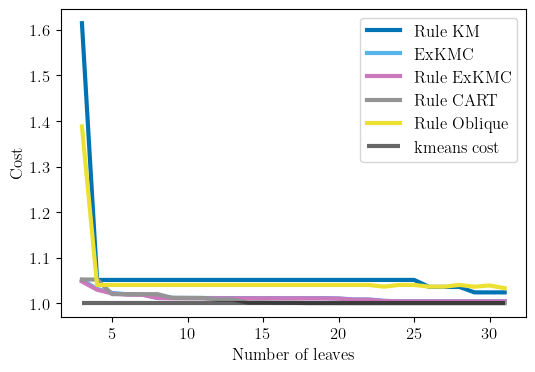

In [196]:
fig,ax = plt.subplots(figsize = (6,4))

ax.plot(leaves, np.array(rule_kmeans_leaves_cost)/cost, linewidth = 3, label = 'Rule KM', c = cmap(0))
#ax.plot(leaves, np.array(rule_kmeans_random_leaves_cost)/cost, linewidth = 3, label = 'Rule ++', c=cmap(2))
ax.plot(leaves, np.array(exkmc_leaves_cost)/cost, linewidth = 3, label = 'ExKMC', c = cmap(9))
ax.plot(leaves, np.array(rule_exkmc_leaves_cost)/cost, linewidth = 3, label = 'Rule ExKMC', c = cmap(4))
ax.plot(leaves, np.array(rule_cart_leaves_cost)/cost, linewidth = 3, label = 'Rule CART', c = cmap(7))
ax.plot(leaves, np.array(rule_oblique_leaves_cost)/cost, linewidth = 3, label = 'Rule Oblique', c = cmap(8))

#ax.hlines(random_tree_cost/cost, xmin = leaves[0], xmax = leaves[-1], color = 'k', linestyle = 'dotted', label = 'Random Tree', linewidth = 3, alpha = 0.6)
#ax.hlines(imm_cost/cost, xmin = leaves[0], xmax = leaves[-1], color = 'k', linestyle = '--', label = 'IMM Tree', linewidth = 3, alpha = 0.6)
ax.hlines(cost/cost, xmin = leaves[0], xmax = leaves[-1], color = 'k', linestyle = '-', label = 'kmeans cost', linewidth = 3, alpha = 0.6)

plt.legend(loc = 'upper right')
ax.set_xlabel('Number of leaves')
ax.set_ylabel('Cost')

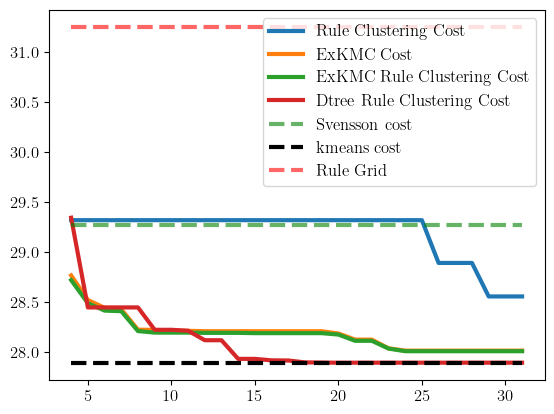

In [57]:
plt.plot(leaves, exkmc_cost_by_leaves, linewidth = 3, label = 'ExKMC')
plt.plot(leaves, rule_kmeans_leaves_cost, linewidth = 3, label = 'Rule KMeans')
plt.plot(leaves, rule_cost_by_leaves1, linewidth = 3, label = 'ExKMC Rule Clustering Cost')
plt.plot(leaves, rule_cost_by_leaves2, linewidth = 3, label = 'Dtree Rule Clustering Cost')
plt.plot(leaves, rule_cost_by_leaves2, linewidth = 3, label = 'Dtree Rule Clustering Cost')
#plt.hlines(random_tree_cost, xmin = leaves[0], xmax = leaves[-1], color = 'green', linestyle = '--', label = 'Svensson cost', linewidth = 3, alpha = 0.6)
plt.hlines(kmeans_cost(data, labels_to_clustering(kmeans.labels_), kmeans.cluster_centers_), xmin = leaves[0], xmax = leaves[-1], color = 'k', linestyle = '--', label = 'kmeans cost', linewidth = 3)
#plt.hlines(rule_grid_cost, xmin = leaves[0], xmax = leaves[-1], color = 'red', linestyle = '--', label = 'Rule Grid', linewidth = 3, alpha = 0.6)
plt.legend()

### 2. k-Medians

In [133]:
rule_kmedians = KMediansRuleClustering(kmedians_rules, k_clusters = k, init = 'random++', n_init = 10)
rule_kmedians.fit(data)
rule_kmedians_labels = rule_kmedians.predict(data)

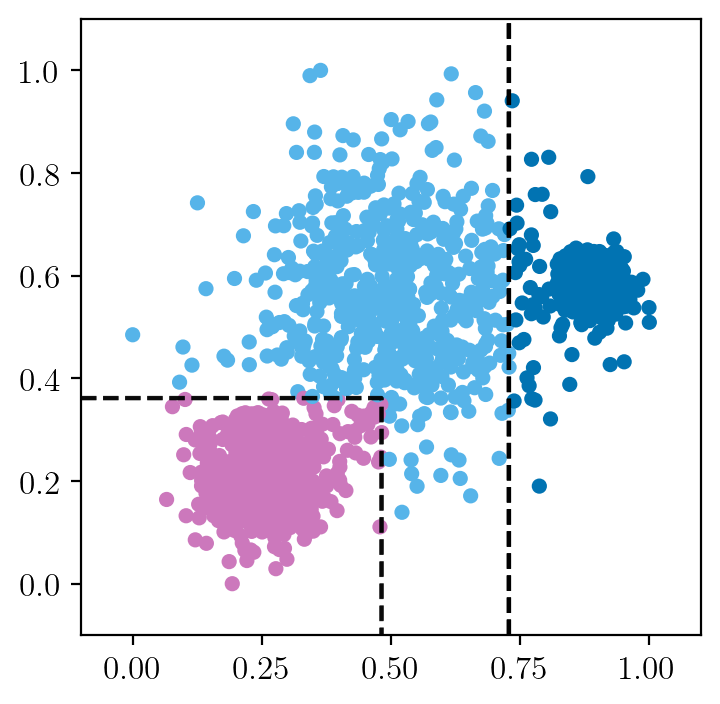

In [134]:
#plt.scatter(rule_kmeans.centers[:,0], rule_kmeans.centers[:,1], color = 'k', marker = 'x', s = 100)
colorswitch = {0:1, 1:0, 2:2}
rule_kmedians_labels_ = np.array([colorswitch[i] for i in rule_kmedians_labels])

fig,ax = plt.subplots(figsize = (4,4), dpi = 200)
scatter = ax.scatter(data[:,0], data[:,1], c = rule_kmedians_labels, cmap = cmap_subset, s = 20)
plot_decision_boundaries(rule_kmedians, data, ax = ax, resolution = 1000)

# Dataset Demonstration

In [77]:
n_samples = 500
seed = 30
noisy_circles = datasets.make_circles(
    n_samples=n_samples, factor=0.5, noise=0.05, random_state=seed
)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05, random_state=seed)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=seed)
rng = np.random.RandomState(seed)
no_structure = rng.rand(n_samples, 2), np.zeros(n_samples)

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

dataset_list = [noisy_circles, noisy_moons, blobs, aniso, varied, no_structure]

C:\Users\kq146\AppData\Local\Temp\ipykernel_28892\3927023097.py:97: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


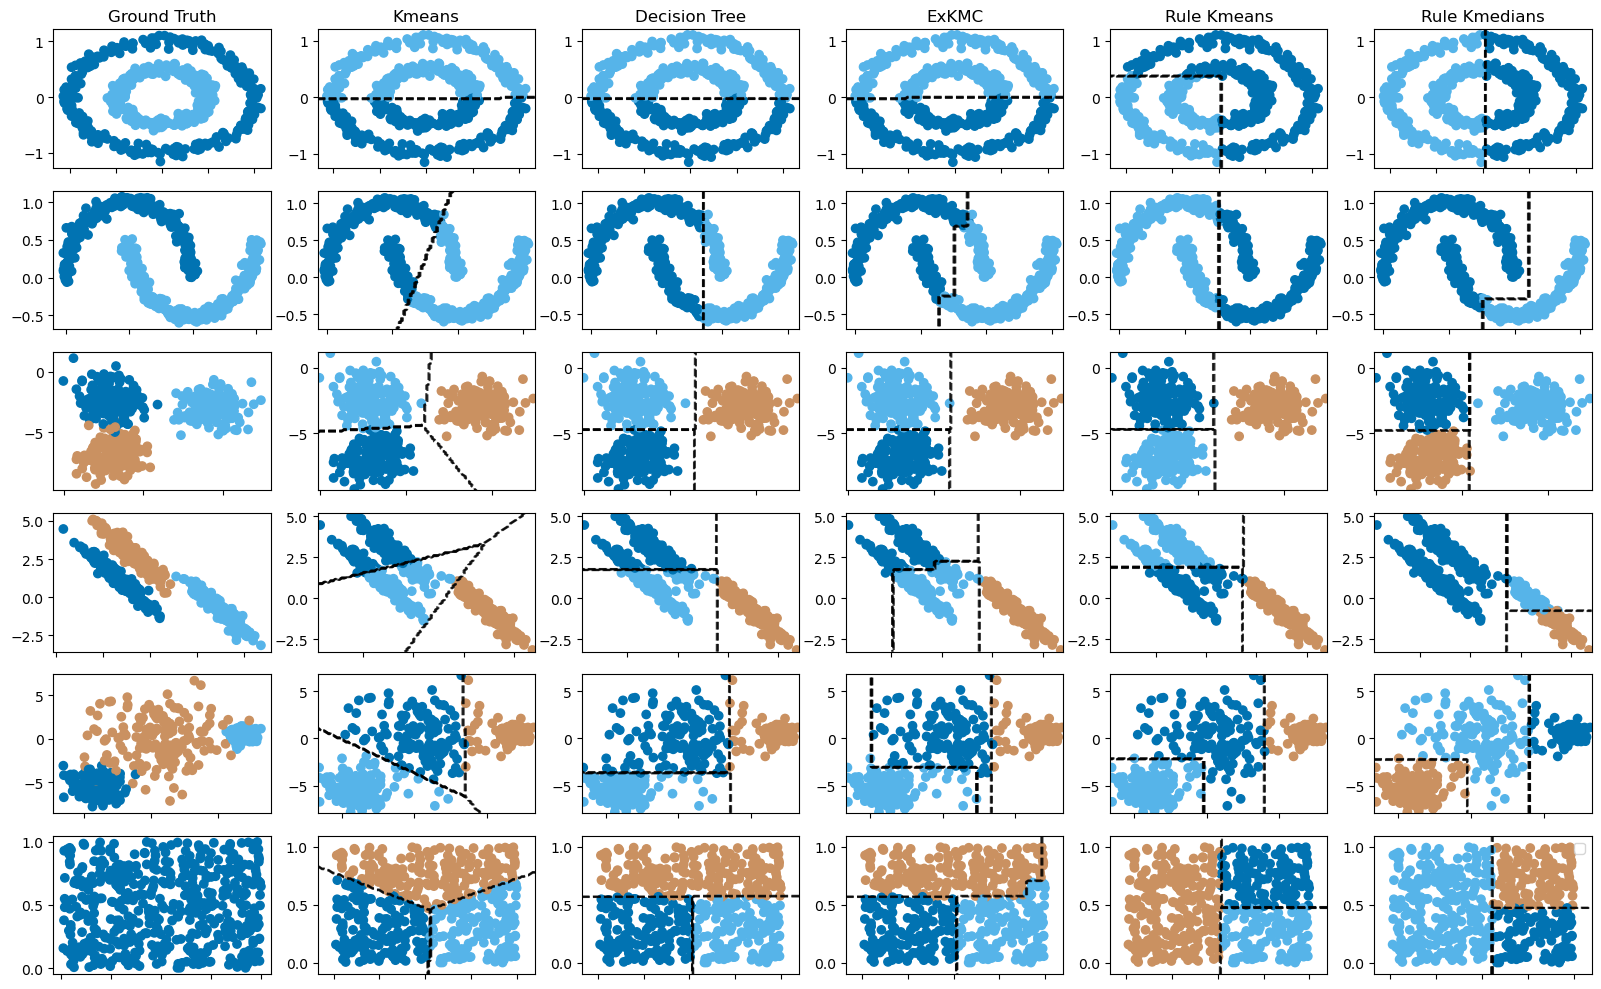

In [78]:
# Cluster and display Results
fig,axes = plt.subplots(6,6, figsize = (16,10))

# For each of the datasets do clusters
for d in range(len(dataset_list)):
    # Set titles
    if d == 0:
        axes[d,0].set_title('Ground Truth')
        axes[d,1].set_title('Kmeans')
        axes[d,2].set_title('Decision Tree')
        axes[d,3].set_title('ExKMC')
        axes[d,4].set_title('Rule Kmeans')
        axes[d,5].set_title('Rule Kmedians')
        #axes[d,5].set_title('Rule Agglomerative')
    
    X,y = dataset_list[d]

    # determine the number of clusters
    if np.sum(y) == 0:
        n_clusters = 3
    else:
        n_clusters = len(np.unique(y))

    # Baseline:
    axes[d,0].scatter(X[:,0], X[:,1], c = y, cmap = cmap)
    axes[d,0].set_xticklabels([])

    # Kmeans:
    kmeans = KMeans(n_clusters=n_clusters, random_state=39, n_init="auto").fit(X)
    axes[d,1].scatter(X[:,0], X[:,1], c = kmeans.labels_, cmap = cmap)
    plot_decision_boundaries(kmeans, X, ax = axes[d,1])
    axes[d,1].set_xticklabels([])

    # Decision tree
    tree = DecisionTreeClassifier(criterion = 'entropy', max_leaf_nodes = n_clusters).fit(X, kmeans.labels_)
    tree_labels = tree.predict(X)
    axes[d,2].scatter(X[:,0], X[:,1], c = tree_labels, cmap = cmap)
    plot_decision_boundaries(tree, X, ax = axes[d,2])
    axes[d,2].set_xticklabels([])

    # ExKMC
    ExKMC_tree = ExTree(n_clusters, max_leaves = 6)
    exkmc_labels = ExKMC_tree.fit_predict(X, kmeans)
    axes[d,3].scatter(X[:,0], X[:,1], c = exkmc_labels, cmap = cmap)
    plot_decision_boundaries(ExKMC_tree, X, ax = axes[d,3])
    axes[d,3].set_xticklabels([])

    # Rule K-means
    kmeans_tree = KMeansTree(max_leaf_nodes = 6, min_points_leaf = 1)
    kmeans_tree.fit(X)
    kmeans_rules = tree_to_rules().traverse(kmeans_tree.root)
    rule_kmeans = KMeansRuleClustering(kmeans_rules, k_clusters = n_clusters, init = 'k-means', max_iterations = 500)
    rule_kmeans.fit(X)
    rule_kmeans_labels = rule_kmeans.predict(X)
    
    axes[d,4].scatter(X[:,0], X[:,1], c = rule_kmeans_labels, cmap = cmap)
    plot_decision_boundaries(rule_kmeans, X, ax = axes[d,4])
    axes[d,4].set_xticklabels([])

    # Rule k-Medians
    kmedians_tree = KMediansTree(max_leaf_nodes = 6, min_points_leaf = 1)
    kmedians_tree.fit(X)
    kmedians_rules = tree_to_rules().traverse(kmedians_tree.root)
    rule_kmedians = KMediansRuleClustering(kmedians_rules, k_clusters = n_clusters, init = 'k-medians', max_iterations = 500)
    rule_kmedians.fit(X)
    rule_kmedians_labels = rule_kmedians.predict(X)
    axes[d,5].scatter(X[:,0], X[:,1], c = rule_kmedians_labels, cmap = cmap)
    plot_decision_boundaries(rule_kmedians, X, ax = axes[d,5])
    axes[d,5].set_xticklabels([])

    # Rule Agglomerative:
    '''
    D_single = compute_distance_matrix(X, kmeans_rules, rule_single_linkage_distance)
    AggCluster = AgglomerativeRuleClustering(kmeans_rules, k_clusters = 4, linkage = 'single')
    AggCluster.fit(X, D_single)
    AggCluster_labels = AggCluster.predict(X)
    
    axes[d,5].scatter(X[:,0], X[:,1], c = AggCluster_labels)
    plot_decision_boundaries(AggCluster, X, ax = axes[d,5])
    unique_labels = np.unique(AggCluster_labels)
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=10, label='Unclustered') for label in unique_labels if label == -1]
    axes[d,5].legend(handles=handles)
    axes[d,5].set_xticklabels([])
    '''
        

# Loop through each subplot
for i, ax in enumerate(axes.flat):
    #ax.plot(x, y)
    
    # Hide x-axis labels for all subplots except those in the last row
    if i < 5 * 5:  # If the subplot is not in the last row
        ax.set_xticklabels([])

# Adjust the layout
plt.tight_layout()
plt.legend()